# Biharmonic Equation in 2D Cartesian Coordinates

**Settings**

The Biharmonic function in 2d cartesian coordinates is:
\begin{equation}
\nabla^4 \phi = \nabla^2 (\nabla^2 \phi) = \frac{\partial^4 \phi}{\partial x^4} + 2 \frac{\partial^4 \phi}{\partial x^2 \partial y^2} + \frac{\partial^4 \phi}{\partial y^4} = 0
\end{equation}

With the boundary conditions:

\begin{equation}
\frac{\partial \phi}{\partial x} = \frac{\partial \phi}{\partial y} = 0, \quad & \text{when } y = 0 \text{ and } y = 1  \\
\frac{\partial \phi}{\partial x} = 0, \frac{\partial \phi}{\partial y} = f(y), \quad & \text{when } x = 0 \\
\frac{\partial \phi}{\partial x} = 0, \frac{\partial \phi}{\partial y} = g(y), \quad & \text{when } x = 1 
\end{equation}

where assume 
\begin{equation}
f(y) = g(y) = 
\begin{cases}
C * ((\lambda /2)^2 - (y-1/2)^2) \qquad & 1/2 - \lambda/2 < y < 1/2 + \lambda/2\\
0 \qquad &  \text{elsewhere}
\end{cases}
 
\end{equation}

### Central Difference Discretization

In this script:

1. A 2D grid is created using `Nx` and `Ny` to specify the number of points in each direction.
2. A mapping function `idx(i, j)` is defined to convert 2D grid coordinates to a single index for a 1D array representation.
3. The matrix `A` is constructed using a finite difference approximation suitable for the biharmonic operator, considering the appropriate coefficients for the fourth derivatives.
4. Neumann boundary conditions are applied to `A` by setting the first derivative to zero at the grid points adjacent to the boundaries using a first-order finite difference approximation.
5. The matrix `A` is converted to Compressed Sparse Row (CSR) format for efficient storage and solving.
6. The linear system is solved using `spsolve`, and the solution `phi` is reshaped back into a 2D array.
7. The solution is plotted using `matplotlib` to visualize the function ($\phi$).



In [1]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

In [2]:
# Define the grid
Nx, Ny = 100, 100  # number of grid points in x and y direction
x = np.linspace(0, 1, Nx+1)
y = np.linspace(0, 1, Ny+1)
dx, dy = x[1] - x[0], y[1] - y[0]

# Count the number of rows in the matrix A
count_row = 0


In [3]:
# Initialize the discretization matrix and right-hand side vector
A = np.zeros(((Nx+1) * (Ny+1), (Nx+1) * (Ny+1))) 
b = np.zeros((Nx+1) * (Ny+1)) # the right-hand side vector, len(b) = the number of rows in A
# U = [U00, U10 ... UN0, U10, U01, U11 ... UN1 ... U0N, U1N ... UNN] with length (N+1)^2


In [4]:
# Define function f(y) and g(y)
def f(z, C = 30, lamb = 2/10):
    # Step function
    if 1/2 - lamb/2 < z < 1/2 + lamb/2:
        return C * ((lamb/2)**2 - (z-1/2)**2)
    else:
        return 0

def g(z):
    return f(z)  # Since g(y) = f(y) in the problem definition

In [5]:
# internal points
# for i in range(2, Nx - 1):  # Start from 2 and end at Nx-2 to avoid out-of-bounds
# for j in range(2, Ny - 1):  # Start from 2 and end at Ny-2 for the same reason
# Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + Ui,j-2 - 8Ui,j-1 - 8Ui,j+1 + Ui,j+2 + 2Ui-1,j-1 + 2Ui-1,j+1 + 2Ui+1,j-1 + 2Ui+1,j+1 = 0
# rearranging the equation in the same order as the U vector
# Ui,j-2 + 2Ui-1,j-1 - 8Ui,j-1 + 2Ui+1,j-1 + Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + 2Ui-1,j+1 - 8Ui,j+1 + 2Ui+1,j+1 + Ui,j+2 = 0

# boundary points
# if j == 0 or j == Ny: 
# for i in range(1, Nx):  # Start from 1 and end at Nx-1 to avoid out-of-bounds
# leapfrog finite difference approximation for the first derivative in BC
# dphi/dx = 0 => (- Ui-1,j + Ui+1,j) / (2*dx) = 0
# (- Ui-1,0 + Ui+1,0) / (2*dx) = 0
# (- Ui-1,Ny + Ui+1,Ny) / (2*dx) = 0

# if i == 0 or i == Nx:
# leapfrog finite difference approximation for the first derivative in BC
# for j in range(1, Ny):  # Start from 1 and end at Ny-1 to avoid out-of-bounds
# dphi/dy = f(y) or g(y) => (Ui,j+1 - Ui,j-1) / (2*dy) = f(j*dy) or g(j*dy)
# (- U0,j-1 + U0,j+1)/ (2*dy) = f(j*dy)
# (- UNx,j-1 + UNx,j+1)/ (2*dy) = g(j*dy)

# four corner points
# second-order forward/backward finite difference approximation for the first derivative
# if i == 0 and j == 0:
# -3/2 U0,0 +2 U1,0 -1/2 U2,0 = 0

# if i == 0 and j == Ny:
# -3/2 U0,Ny +2 U1,Ny -1/2 U2,Ny = 0

# if i == Nx and j == 0:
# 1/2 UNx-2,0 -2 UNx-1,0 +3/2 UNx,0 = 0

# if i == Nx and j == Ny:
# 1/2 UNx-2,Ny -2 UNx-1,Ny +3/2 UNx,Ny = 0

# i, j = 1 or Nx-1 square points
# if j == 1 and i in range(2, Nx-1): avoid the corner points
# from bc we have: Ui,-1 = Ui,1
# Ui,-1 + 2Ui-1,0 - 8Ui,0 + 2Ui+1,0 + Ui-2,1 - 8Ui-1,1 + 20Ui,1 - 8Ui+1,1 + Ui+2,1 + 2Ui-1,2 - 8Ui,2 + 2Ui+1,2 + Ui,3 = 0
# so:
# 2Ui-1,0 - 8Ui,0 + 2Ui+1,0 + Ui-2,1 - 8Ui-1,1 + 21Ui,1 - 8Ui+1,1 + Ui+2,1 + 2Ui-1,2 - 8Ui,2 + 2Ui+1,2 + Ui,3 = 0

# if j == Ny-1 and i in range(2, Nx-1): avoid the corner points
# from bc we have: Ui,Ny+1 = Ui,Ny-1
# Ui,Ny-3 + 2Ui-1,Ny-2 - 8Ui,Ny-2 + 2Ui+1,Ny-2 + Ui-2,Ny-1 - 8Ui-1,Ny-1 + 20Ui,Ny-1 - 8Ui+1,Ny-1 + Ui+2,Ny-1 + 2Ui-1,Ny - 8Ui,Ny + 2Ui+1,Ny + Ui,Ny+1 = 0
# so:
# Ui,Ny-3 + 2Ui-1,Ny-2 - 8Ui,Ny-2 + 2Ui+1,Ny-2 + Ui-2,Ny-1 - 8Ui-1,Ny-1 + 21Ui,Ny-1 - 8Ui+1,Ny-1 + Ui+2,Ny-1 + 2Ui-1,Ny - 8Ui,Ny + 2Ui+1,Ny = 0

# if i == 1 and j in range(2, Ny-1): avoid the corner points
# from bc we have: U-1,j = U1,j
# U1,j-2 + 2U0,j-1 - 8U1,j-1 + 2U2,j-1 + U-1,j - 8U0,j + 20U1,j - 8U2,j + U3,j + 2U0,j+1 - 8U1,j+1 + 2U2,j+1 + U1,j+2 = 0
# so:
# U1,j-2 + 2U0,j-1 - 8U1,j-1 + 2U2,j-1 - 8U0,j + 21U1,j - 8U2,j + U3,j + 2U0,j+1 - 8U1,j+1 + 2U2,j+1 + U1,j+2 = 0

# if i == Nx-1 and j in range(2, Ny-1): avoid the corner points
# from bc we have: UNx+1,j = UNx-1,j
# UNx-1,j-2 + 2UNx-2,j-1 - 8UNx-1,j-1 + 2UNx,j-1 + UNx-3,j - 8UNx-2,j + 20UNx-1,j - 8UNx,j + UNx+1,j + 2UNx-2,j+1 - 8UNx-1,j+1 + 2UNx,j+1 + UNx-1,j+2 = 0
# so:
# UNx-1,j-2 + 2UNx-2,j-1 - 8UNx-1,j-1 + 2UNx,j-1 + UNx-3,j - 8UNx-2,j + 21UNx-1,j - 8UNx,j + 2UNx-2,j+1 - 8UNx-1,j+1 + 2UNx,j+1 + UNx-1,j+2 = 0

# four corner points
# if i == 1 and j == 1:
# from bc we have: U1,-1 = U1,1 = U-1,1 
# U1,-1 + 2U0,0 - 8U1,0 + 2U2,0 + U-1,1 - 8U0,1 + 20U1,1 - 8U2,1 + U3,1 + 2U0,2 - 8U1,2 + 2U2,2 + U1,3 = 0
# so:
# 2U0,0 - 8U1,0 + 2U2,0 - 8U0,1 + 22U1,1 - 8U2,1 + U3,1 + 2U0,2 - 8U1,2 + 2U2,2 + U1,3 = 0

# if i == 1 and j == Ny-1:
# from bc we have: U1,Ny+1 = U1,Ny-1 = U-1,Ny-1
# U1,Ny-3 + 2U0,Ny-2 - 8U1,Ny-2 + 2U2,Ny-2 + U-1,Ny-1 - 8U0,Ny-1 + 20U1,Ny-1 - 8U2,Ny-1 + U3,Ny-1 + 2U0,Ny - 8U1,Ny + 2U2,Ny + U1,Ny+1 = 0
# so:
# U1,Ny-3 + 2U0,Ny-2 - 8U1,Ny-2 + 2U2,Ny-2 - 8U0,Ny-1 + 22U1,Ny-1 - 8U2,Ny-1 + U3,Ny-1 + 2U0,Ny - 8U1,Ny + 2U2,Ny = 0

# if i == Nx-1 and j == 1:
# from bc we have: UNx+1,1 = UNx-1,1 = UNx-1,-1
# UNx-1,-1 + 2UNx-2,0 - 8UNx-1,0 + 2UNx,0 + UNx-3,1 - 8UNx-2,1 + 20UNx-1,1 - 8UNx,1 + UNx+1,1 + 2UNx-2,2 - 8UNx-1,2 + 2UNx,2 + UNx-1,3 = 0
# so:
# 2UNx-2,0 - 8UNx-1,0 + 2UNx,0 + UNx-3,1 - 8UNx-2,1 + 22UNx-1,1 - 8UNx,1 + 2UNx-2,2 - 8UNx-1,2 + 2UNx,2 + UNx-1,3 = 0

# if i == Nx-1 and j == Ny-1:
# from bc we have: UNx+1,Ny-1 = UNx-1,Ny-1 = UNx-1,Ny+1
# UNx-1,Ny-3 + 2UNx-2,Ny-2 - 8UNx-1,Ny-2 + 2UNx,Ny-2 + UNx-3,Ny-1 - 8UNx-2,Ny-1 + 22UNx-1,Ny-1 - 8UNx,Ny-1 + 2UNx-2,Ny - 8UNx-1,Ny + 2UNx,Ny = 0


In [6]:
# Function to map 2D grid coordinates to 1D vector index
def idx(i, j):
    return i * (Ny+1) + j


In [7]:
# Fill the matrix A and vector b for the internal points
for i in range(2, Nx - 1):  # Start from 2 and end at Nx-2 to avoid out-of-bounds
    for j in range(2, Ny - 1):  # Start from 2 and end at Ny-2 for the same reason
        index = idx(i, j)
        # Ui,j-2 + 2Ui-1,j-1 - 8Ui,j-1 + 2Ui+1,j-1 + Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + 2Ui-1,j+1 - 8Ui,j+1 + 2Ui+1,j+1 + Ui,j+2 = 0
        A[count_row, idx(i, j-2)] = 1
        A[count_row, idx(i-1, j-1)] = 2
        A[count_row, idx(i, j-1)] = -8
        A[count_row, idx(i+1, j-1)] = 2
        A[count_row, idx(i-2, j)] = 1
        A[count_row, idx(i-1, j)] = -8
        A[count_row, idx(i, j)] = 20
        A[count_row, idx(i+1, j)] = -8
        A[count_row, idx(i+2, j)] = 1
        A[count_row, idx(i-1, j+1)] = 2
        A[count_row, idx(i, j+1)] = -8
        A[count_row, idx(i+1, j+1)] = 2
        A[count_row, idx(i, j+2)] = 1
            
        b[count_row] = 0
        count_row += 1
    
print(f'count_row: {count_row}')

count_row: 9409


In [8]:
# boundary points
# y = 0:
# (- Ui-1,0 + Ui+1,0) / (2*dx) = 0
for i in range(1, Nx):
    A[count_row, idx(i-1, 0)] = -1
    A[count_row, idx(i+1, 0)] = 1
        
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 9508


In [9]:
# boundary points
# y = 1:
# (- Ui-1,Ny + Ui+1,Ny) / (2*dx) = 0
for i in range(1, Nx):
    A[count_row, idx(i-1, Ny)] = -1
    A[count_row, idx(i+1, Ny)] = 1
        
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 9607


In [10]:
# boundary points
# x = 0: 
# (- U0,j-1 + U0,j+1)/ (2*dy) = f(j*dy)
for j in range(1, Ny):
    A[count_row, idx(0, j-1)] = -1/(2*dy)
    A[count_row, idx(0, j+1)] = 1/(2*dy)
        
    b[count_row] = f(j*dy)
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 9706


In [11]:
# boundary points
# x = 1: 
# (- UNx,j-1 + UNx,j+1)/ (2*dy) = g(j*dy)
for j in range(1, Ny):
    A[count_row, idx(Nx, j-1)] = -1/(2*dy)
    A[count_row, idx(Nx, j+1)] = 1/(2*dy)
        
    b[count_row] = g(j*dy)
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 9805


In [12]:
# four corner points
# if i == 0 and j == 0:
# -3/2 U0,0 +2 U1,0 -1/2 U2,0 = 0
A[count_row, idx(0, 0)] = -3/2
A[count_row, idx(1, 0)] = 2
A[count_row, idx(2, 0)] = -1/2
b[count_row] = 0
count_row += 1

# if i == 0 and j == Ny:
# -3/2 U0,Ny +2 U1,Ny -1/2 U2,Ny = 0
A[count_row, idx(0, Ny)] = -3/2
A[count_row, idx(1, Ny)] = 2
A[count_row, idx(2, Ny)] = -1/2
b[count_row] = 0
count_row += 1

# if i == Nx and j == 0:
# 1/2 UNx-2,0 -2 UNx-1,0 +3/2 UNx,0 = 0
A[count_row, idx(Nx-2, 0)] = 1/2
A[count_row, idx(Nx-1, 0)] = -2
A[count_row, idx(Nx, 0)] = 3/2
b[count_row] = 0
count_row += 1

# if i == Nx and j == Ny:
# 1/2 UNx-2,Ny -2 UNx-1,Ny +3/2 UNx,Ny = 0
A[count_row, idx(Nx-2, Ny)] = 1/2
A[count_row, idx(Nx-1, Ny)] = -2
A[count_row, idx(Nx, Ny)] = 3/2
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 9809


In [13]:
# if j == 1 and i in range(2, Nx-1):
# 2Ui-1,0 - 8Ui,0 + 2Ui+1,0 + Ui-2,1 - 8Ui-1,1 + 21Ui,1 - 8Ui+1,1 + Ui+2,1 + 2Ui-1,2 - 8Ui,2 + 2Ui+1,2 + Ui,3 = 0
for i in range(2, Nx-1):
    A[count_row, idx(i-1, 0)] = 2
    A[count_row, idx(i, 0)] = -8
    A[count_row, idx(i+1, 0)] = 2
    A[count_row, idx(i-2, 1)] = 1
    A[count_row, idx(i-1, 1)] = -8
    A[count_row, idx(i, 1)] = 21
    A[count_row, idx(i+1, 1)] = -8
    A[count_row, idx(i+2, 1)] = 1
    A[count_row, idx(i-1, 2)] = 2
    A[count_row, idx(i, 2)] = -8
    A[count_row, idx(i+1, 2)] = 2
    A[count_row, idx(i, 3)] = 1
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 9906


In [14]:
# if j == Ny-1 and i in range(2, Nx-1): 
# Ui,Ny-3 + 2Ui-1,Ny-2 - 8Ui,Ny-2 + 2Ui+1,Ny-2 + Ui-2,Ny-1 - 8Ui-1,Ny-1 + 21Ui,Ny-1 - 8Ui+1,Ny-1 + Ui+2,Ny-1 + 2Ui-1,Ny - 8Ui,Ny + 2Ui+1,Ny = 0
for i in range(2, Nx-1):
    A[count_row, idx(i, Ny-3)] = 1
    A[count_row, idx(i-1, Ny-2)] = 2
    A[count_row, idx(i, Ny-2)] = -8
    A[count_row, idx(i+1, Ny-2)] = 2
    A[count_row, idx(i-2, Ny-1)] = 1
    A[count_row, idx(i-1, Ny-1)] = -8
    A[count_row, idx(i, Ny-1)] = 21
    A[count_row, idx(i+1, Ny-1)] = -8
    A[count_row, idx(i+2, Ny-1)] = 1
    A[count_row, idx(i-1, Ny)] = 2
    A[count_row, idx(i, Ny)] = -8
    A[count_row, idx(i+1, Ny)] = 2
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 10003


In [15]:
# if i == 1 and j in range(2, Ny-1)
# U1,j-2 + 2U0,j-1 - 8U1,j-1 + 2U2,j-1 - 8U0,j + 21U1,j - 8U2,j + U3,j + 2U0,j+1 - 8U1,j+1 + 2U2,j+1 + U1,j+2 = 0
for j in range(2, Ny-1):
    A[count_row, idx(1, j-2)] = 1
    A[count_row, idx(0, j-1)] = 2
    A[count_row, idx(1, j-1)] = -8
    A[count_row, idx(2, j-1)] = 2
    A[count_row, idx(0, j)] = -8
    A[count_row, idx(1, j)] = 21
    A[count_row, idx(2, j)] = -8
    A[count_row, idx(3, j)] = 1
    A[count_row, idx(0, j+1)] = 2
    A[count_row, idx(1, j+1)] = -8
    A[count_row, idx(2, j+1)] = 2
    A[count_row, idx(1, j+2)] = 1
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')


count_row: 10100


In [16]:
# if i == Nx-1 and j in range(2, Ny-1): 
# UNx-1,j-2 + 2UNx-2,j-1 - 8UNx-1,j-1 + 2UNx,j-1 + UNx-3,j - 8UNx-2,j + 21UNx-1,j - 8UNx,j + 2UNx-2,j+1 - 8UNx-1,j+1 + 2UNx,j+1 + UNx-1,j+2 = 0
for j in range(2, Ny-1):
    A[count_row, idx(Nx-1, j-2)] = 1
    A[count_row, idx(Nx-2, j-1)] = 2
    A[count_row, idx(Nx-1, j-1)] = -8
    A[count_row, idx(Nx, j-1)] = 2
    A[count_row, idx(Nx-3, j)] = 1
    A[count_row, idx(Nx-2, j)] = -8
    A[count_row, idx(Nx-1, j)] = 21
    A[count_row, idx(Nx, j)] = -8
    A[count_row, idx(Nx-2, j+1)] = 2
    A[count_row, idx(Nx-1, j+1)] = -8
    A[count_row, idx(Nx, j+1)] = 2
    A[count_row, idx(Nx-1, j+2)] = 1
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 10197


In [17]:
# four corner points
# if i == 1 and j == 1:
# 2U0,0 - 8U1,0 + 2U2,0 - 8U0,1 + 22U1,1 - 8U2,1 + U3,1 + 2U0,2 - 8U1,2 + 2U2,2 + U1,3 = 0
A[count_row, idx(0, 0)] = 2
A[count_row, idx(1, 0)] = -8
A[count_row, idx(2, 0)] = 2
A[count_row, idx(0, 1)] = -8
A[count_row, idx(1, 1)] = 22
A[count_row, idx(2, 1)] = -8
A[count_row, idx(3, 1)] = 1
A[count_row, idx(0, 2)] = 2
A[count_row, idx(1, 2)] = -8
A[count_row, idx(2, 2)] = 2
A[count_row, idx(1, 3)] = 1
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 10198


In [18]:
# if i == 1 and j == Ny-1:
# U1,Ny-3 + 2U0,Ny-2 - 8U1,Ny-2 + 2U2,Ny-2 - 8U0,Ny-1 + 22U1,Ny-1 - 8U2,Ny-1 + U3,Ny-1 + 2U0,Ny - 8U1,Ny + 2U2,Ny = 0
A[count_row, idx(1, Ny-3)] = 1
A[count_row, idx(0, Ny-2)] = 2
A[count_row, idx(1, Ny-2)] = -8
A[count_row, idx(2, Ny-2)] = 2
A[count_row, idx(0, Ny-1)] = -8
A[count_row, idx(1, Ny-1)] = 22
A[count_row, idx(2, Ny-1)] = -8
A[count_row, idx(3, Ny-1)] = 1
A[count_row, idx(0, Ny)] = 2
A[count_row, idx(1, Ny)] = -8
A[count_row, idx(2, Ny)] = 2
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')


count_row: 10199


In [19]:
# if i == Nx-1 and j == 1:
# 2UNx-2,0 - 8UNx-1,0 + 2UNx,0 + UNx-3,1 - 8UNx-2,1 + 22UNx-1,1 - 8UNx,1 + 2UNx-2,2 - 8UNx-1,2 + 2UNx,2 + UNx-1,3 = 0
A[count_row, idx(Nx-2, 0)] = 2
A[count_row, idx(Nx-1, 0)] = -8
A[count_row, idx(Nx, 0)] = 2
A[count_row, idx(Nx-3, 1)] = 1
A[count_row, idx(Nx-2, 1)] = -8
A[count_row, idx(Nx-1, 1)] = 22
A[count_row, idx(Nx, 1)] = -8
A[count_row, idx(Nx-2, 2)] = 2
A[count_row, idx(Nx-1, 2)] = -8
A[count_row, idx(Nx, 2)] = 2
A[count_row, idx(Nx-1, 3)] = 1
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 10200


In [20]:
# if i == Nx-1 and j == Ny-1:
# UNx-1,Ny-3 + 2UNx-2,Ny-2 - 8UNx-1,Ny-2 + 2UNx,Ny-2 + UNx-3,Ny-1 - 8UNx-2,Ny-1 + 22UNx-1,Ny-1 - 8UNx,Ny-1 + 2UNx-2,Ny - 8UNx-1,Ny + 2UNx,Ny = 0
A[count_row, idx(Nx-1, Ny-3)] = 1
A[count_row, idx(Nx-2, Ny-2)] = 2
A[count_row, idx(Nx-1, Ny-2)] = -8
A[count_row, idx(Nx, Ny-2)] = 2
A[count_row, idx(Nx-3, Ny-1)] = 1
A[count_row, idx(Nx-2, Ny-1)] = -8
A[count_row, idx(Nx-1, Ny-1)] = 22
A[count_row, idx(Nx, Ny-1)] = -8
A[count_row, idx(Nx-2, Ny)] = 2
A[count_row, idx(Nx-1, Ny)] = -8
A[count_row, idx(Nx, Ny)] = 2
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 10201


In [21]:
# show the matrix A in detail
A

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  2., -8.,  2.]])

In [22]:
# Solve the linear system
U, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)


In [23]:
# Convert the solution to a 2D grid
phi = U.reshape((Nx+1, Ny+1))

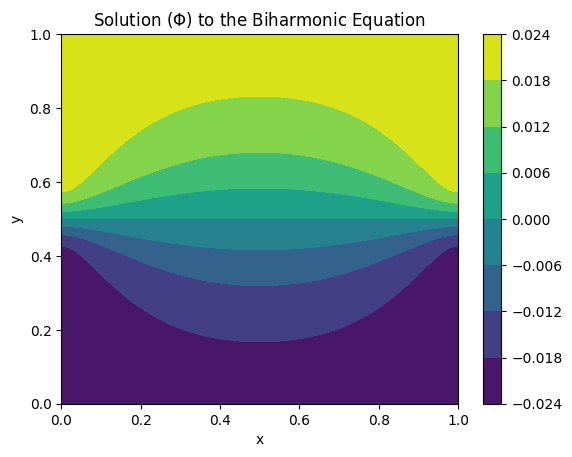

In [42]:
# Plot the solution
import matplotlib.pyplot as plt

X, Y = np.meshgrid(x, y)
plt.contourf(Y, X, phi, cmap='viridis')
plt.colorbar()
plt.title('Solution ($\Phi$) to the Biharmonic Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


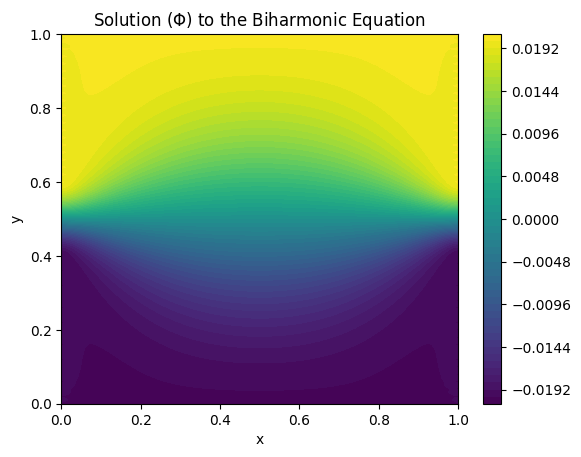

In [43]:
# Level plot with 50 levels
X, Y = np.meshgrid(x, y)

plt.contourf(Y, X, phi, levels=50, cmap='viridis')  # Increase to 50 levels
plt.colorbar()
plt.title('Solution ($\Phi$) to the Biharmonic Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


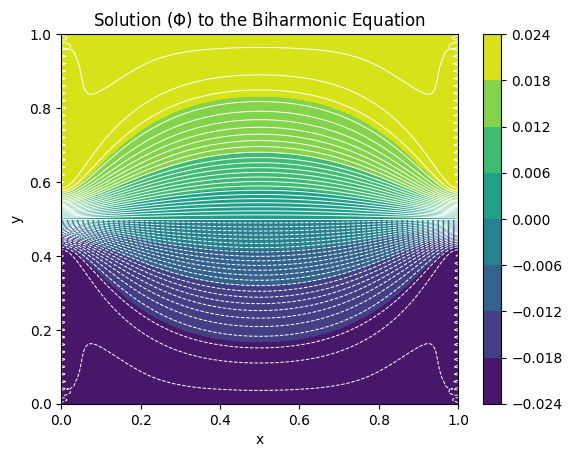

In [44]:
# Contour plot with white contour lines
X, Y = np.meshgrid(x, y)

plt.contourf(Y, X, phi, cmap='viridis')  # Filled contour plot
plt.colorbar()  # Color bar for reference

# Add contour lines over the filled contour plot
plt.contour(Y, X, phi, colors='w', levels=50, linewidths=0.7)  # Example: red color lines with width of 2

plt.title('Solution ($\Phi$) to the Biharmonic Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [45]:
# Calculate gradients
grad_y, grad_x= np.gradient(phi)
u_x = grad_y
u_y = -grad_x

# Calculate the velocity magnitude
velocity_magnitude = np.sqrt(u_x**2 + u_y**2)


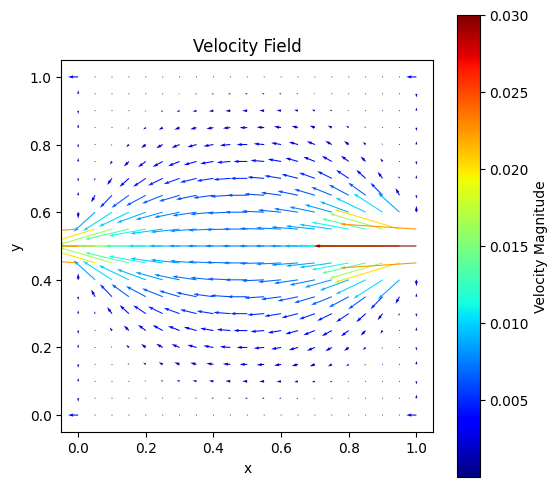

In [48]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Scale u_x and u_y for better visualization
u_x_scale = u_x * 10
u_y_scale = u_y * 10

# Calculate the velocity magnitude
velocity_magnitude_scale = np.sqrt(u_x_scale**2 + u_y_scale**2)

# Create a meshgrid for plotting
X, Y = np.meshgrid(x, y)

# Select a step size for slicing; higher numbers will have fewer vectors
step = 5  # Adjust this to change the density of the vectors

# Slice the arrays to reduce the number of vectors
Y_slice = Y[::step, ::step]
X_slice = X[::step, ::step]
u_x_slice = u_x_scale[::step, ::step]
u_y_slice = u_y_scale[::step, ::step]
velocity_magnitude_slice = velocity_magnitude_scale[::step, ::step]

# Plot the velocity field
fig, ax = plt.subplots()
fig.set_size_inches(6, 6) # Adjust figure size

quiver = ax.quiver(Y_slice, X_slice, u_y_slice,u_x_slice, velocity_magnitude_slice,
                   angles='xy', scale_units='xy', scale=0.1, cmap=cm.jet)
ax.set_aspect('equal')
ax.set_title('Velocity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Adding a colorbar to represent the velocity magnitude
cbar = fig.colorbar(quiver, ax=ax)
cbar.set_label('Velocity Magnitude')

plt.show()



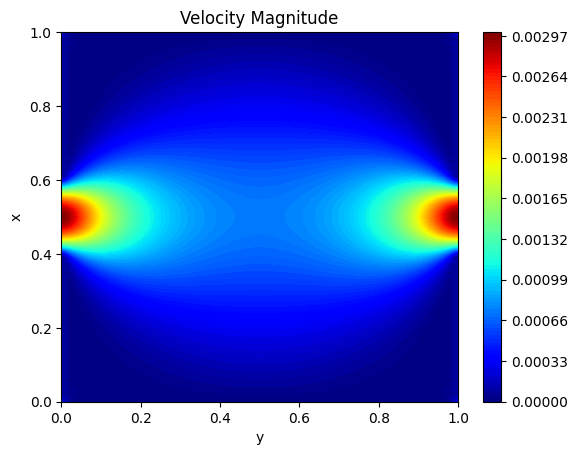

In [49]:
# Plot contours of the velocity magnitude
# adjust the figure size
fig, ax = plt.subplots()
plt.contourf(Y, X, velocity_magnitude, cmap=cm.jet, levels=100)
plt.colorbar()
plt.title('Velocity Magnitude')
plt.xlabel('y')
plt.ylabel('x')
plt.show()



[ 2.01387479e-02 -5.03198241e-03 -2.85832327e-03 -1.26360934e-03
 -5.18569718e-04 -2.09350392e-04 -8.49457572e-05 -3.43785532e-05
 -1.30705995e-05 -3.59359688e-06  9.20554735e-07  3.26339521e-06
  4.62519370e-06  5.54558358e-06  6.28817497e-06  6.99435225e-06
  7.74993971e-06  8.61619406e-06  9.64567917e-06  1.08916848e-05
  1.24151515e-05  1.42912022e-05  1.66167260e-05  1.95204275e-05
  2.31771765e-05  2.78294637e-05  3.38206086e-05  4.16478051e-05
  5.20496044e-05  6.61550578e-05  8.57465073e-05  1.13736138e-04
  1.55044128e-04  2.18193415e-04  3.17949585e-04  4.78257264e-04
  7.27763766e-04  1.04604185e-03  1.06658044e-03 -1.30295758e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.30295

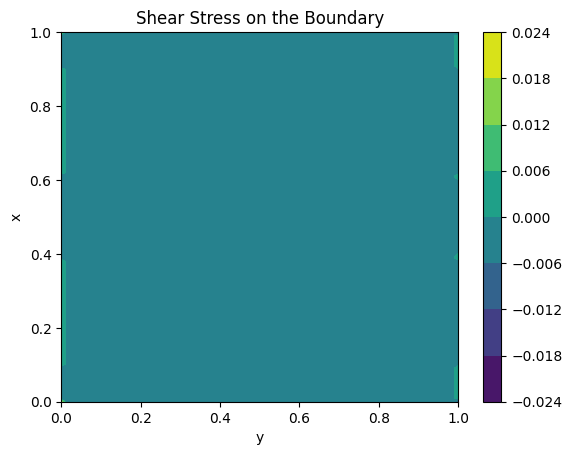

In [53]:
# Calculate the shear stress on the boundary
# The shear stress is given by the formula: tau = partial u_y / partial x

tau = np.zeros((Nx+1, Ny+1))
lamb = 2/10  # Width of the boundary region

# Calculate the shear stress at the boundary points using 2nd order forward/backward finite difference approximation
for j in range(Ny+1):
    if 1/2 - lamb/2 > j*dy or j*dy > 1/2 + lamb/2:
        # x = 0: partial u_y / partial x = (-1/2* u_y[2, j] + 2 * u_y[1, j] -3/2* u_y[0, j]) / dx
        tau[0, j] = (-1/2 * u_y[2, j] + 2 * u_y[1, j] - 3/2 * u_y[0, j]) / dx
        # x = 1: partial u_y / partial x = (1/2* u_y[Nx-2, j] - 2 * u_y[Nx-1, j] +3/2* u_y[Nx, j]) / dx
        tau[Nx, j] = (1/2 * u_y[Nx-2, j] - 2 * u_y[Nx-1, j] + 3/2 * u_y[Nx, j]) / dx
    
print(tau[0, :])
print(tau[Nx, :])

# Plot the shear stress
X, Y = np.meshgrid(x, y)
plt.contourf(Y, X, tau, cmap='viridis')
plt.colorbar()
plt.title('Shear Stress on the Boundary')
plt.xlabel('y')
plt.ylabel('x')
plt.show()


# Shear Stress on the Boundary

For $x = 0$ and $x=1$, the shear stress is given by 

\begin{equation}
\tau = \frac{\partial U_y}{\partial x}, 
\end{equation}

where $U_y = -\frac{\partial \Phi}{\partial x}$. Hence, we have

\begin{equation}
\tau = -\frac{\partial^2 \Phi}{\partial x^2}.
\end{equation} 

Shear stress at x=0: [ 3.00000002e-04  1.04888682e-04  2.29693254e-05  3.64413471e-07
 -3.89042678e-06 -3.70014253e-06 -2.78432207e-06 -1.95374116e-06
 -1.31555311e-06 -8.41678342e-07 -4.94339882e-07 -2.46089369e-07
 -7.88245448e-08  1.95381663e-08  5.75277312e-08  4.16310481e-08
 -2.28230612e-08 -1.31154627e-07 -2.79043218e-07 -4.62368930e-07
 -6.77131532e-07 -9.19416641e-07 -1.18538979e-06 -1.47130634e-06
 -1.77352943e-06 -2.08855103e-06 -2.41301285e-06 -2.74372517e-06
 -3.07768236e-06 -3.41207462e-06 -3.74429572e-06 -4.07194676e-06
 -4.39283643e-06 -4.70497794e-06 -5.00658329e-06 -5.29605512e-06
 -5.57197690e-06 -5.83310169e-06 -6.07834000e-06 -6.30674719e-06
 -6.51751066e-06 -6.70993716e-06 -6.88344059e-06 -7.03753035e-06
 -7.17180058e-06 -7.28592029e-06 -7.37962467e-06 -7.45270757e-06
 -7.50501522e-06 -7.53644132e-06 -7.54692354e-06 -7.53644132e-06
 -7.50501522e-06 -7.45270757e-06 -7.37962467e-06 -7.28592029e-06
 -7.17180058e-06 -7.03753035e-06 -6.88344059e-06 -6.70993716e-06
 -6.

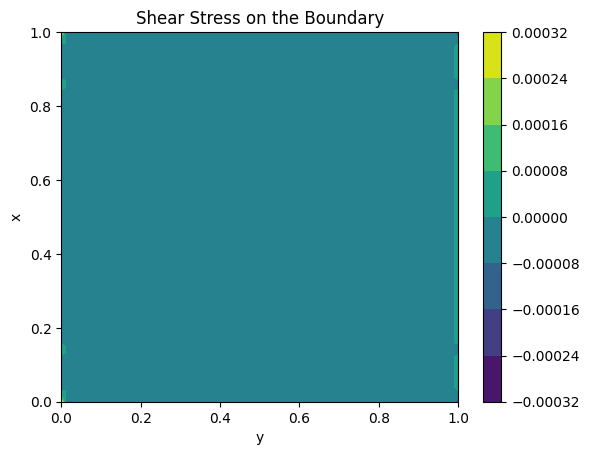

In [54]:
# Calculate the shear stress on the boundary
tau = np.zeros((Nx+1, Ny+1))

def compute_shear_stress(Phi):
    # Compute the second derivative of Phi with respect to x
    # We use np.gradient to compute the first derivative twice
    dPhi_dx = np.gradient(Phi, axis=1) # axis=1 because we assume the second dimension is x
    d2Phi_dx2 = np.gradient(dPhi_dx, axis=1)
    
    # The shear stress at the boundaries (x=0 and x=-1) can then be extracted
    tau_x0 = -d2Phi_dx2[:, 0]   # Shear stress at x=0
    tau_x1 = -d2Phi_dx2[:, -1]  # Shear stress at x=1
    
    return tau_x0, tau_x1

# tau_x0 and tau_x1 contain the shear stress at the x=0 and x=1 boundaries, respectively
tau_x0, tau_x1 = compute_shear_stress(phi)
# Print the shear stress at the boundaries
print(f'Shear stress at x=0: {tau_x0}')
print(f'Shear stress at x=1: {tau_x1}')

# Change the tau array to store the shear stress at the boundaries
tau[0, :] = tau_x0
tau[Nx, :] = tau_x1

# Plot the shear stress
X, Y = np.meshgrid(x, y)
plt.contourf(Y, X, tau, cmap='viridis')
plt.colorbar()
plt.title('Shear Stress on the Boundary')
plt.xlabel('y')
plt.ylabel('x')
plt.show()



## Realistic Test Case

1. Change the boundary condition on the outlet to be constant velocity $U$ instead of the parabolic profile (mind that it should generate the same flow as the inlet, so $U*\lambda=Q$, where $\lambda$ is the width of the outlet and $Q = \lambda ^2$ is the flow rate at the inlet).


2. try different positioning and size of the outlet, and maybe add more inlets/outlets.